## Data import and cleaning

In [113]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#Install yfinance and import Data
import yfinance as yf
from yfinance import Ticker

In [6]:
# set parameters for yfinance data
tickers = ['AAPL', 'GOOGL', 'MSFT', 'IBM']
start_date = datetime.strptime('01 01 2013', '%d %m %Y')
end_date = datetime.strptime('31 12 2023', '%d %m %Y')

In [ ]:
# obtain data
dfs = {}
for ticker in tickers:
    ticker_obj = Ticker(ticker)
    history = ticker_obj.history(start=start_date, end=end_date)
    dfs[ticker] = pd.DataFrame(history)
    #dfs[ticker].index = dfs[ticker].index.date
    #dfs[ticker].index = dfs[ticker].index.strftime('%Y-%m-%d')
    #print(f"{ticker} closing prices: {history['Close']}")

In [66]:
df_aapl = dfs['AAPL']
df_googl = dfs['GOOGL']
df_msft = dfs['MSFT']
df_ibm = pd.DataFrame(dfs['IBM']['Close'])

In [70]:
#df_ibm = df_ibm.set_index('Date', inplace=False)
#df_ibm.columns = df_ibm.columns.droplevel(0)
#df_ibm = df_ibm.reset_index(inplace=False)

df_ibm

,Close
Date,
2013-01-02 00:00:00-05:00,121.021301
2013-01-03 00:00:00-05:00,120.355659
2013-01-04 00:00:00-05:00,119.566742
2013-01-07 00:00:00-05:00,119.042892
2013-01-08 00:00:00-05:00,118.876350
...,...
2023-12-22 00:00:00-05:00,162.139999
2023-12-26 00:00:00-05:00,163.210007
2023-12-27 00:00:00-05:00,163.460007


### Missing dates

In [99]:
# Create a complete date range for the period covered by the data
complete_dates = pd.date_range(start=df_ibm.index.min(), end=df_ibm.index.max())
complete_dates

DatetimeIndex(['2013-01-02 00:00:00-05:00', '2013-01-03 00:00:00-05:00',
               '2013-01-04 00:00:00-05:00', '2013-01-05 00:00:00-05:00',
               '2013-01-06 00:00:00-05:00', '2013-01-07 00:00:00-05:00',
               '2013-01-08 00:00:00-05:00', '2013-01-09 00:00:00-05:00',
               '2013-01-10 00:00:00-05:00', '2013-01-11 00:00:00-05:00',
               ...
               '2023-12-20 00:00:00-05:00', '2023-12-21 00:00:00-05:00',
               '2023-12-22 00:00:00-05:00', '2023-12-23 00:00:00-05:00',
               '2023-12-24 00:00:00-05:00', '2023-12-25 00:00:00-05:00',
               '2023-12-26 00:00:00-05:00', '2023-12-27 00:00:00-05:00',
               '2023-12-28 00:00:00-05:00', '2023-12-29 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', length=4014, freq='D')

In [104]:
# Merge the data with the complete date range
merged_df = df_ibm.reindex(complete_dates)
merged_df.isna().sum()

Close    1246
dtype: int64

In [87]:
# Identify missing dates
missing_dates = merged_df[merged_df['Close'].isnull()].index
len(missing_dates)

1246

In [89]:
missing_dates = merged_df[merged_df['Close'].isnull()].index

missing_dates_df = pd.DataFrame(missing_dates, columns=['date'])
missing_dates_df['weekday'] = missing_dates_df['date'].dt.weekday

# Count the number of missing dates for each weekday
missing_counts = missing_dates_df.groupby('weekday').size().reset_index()
missing_counts.columns = ['weekday', 'nulls']
missing_counts

,weekday,nulls
0,0,56
1,1,4
2,2,6
3,3,15
4,4,19
5,5,573
6,6,573


In [103]:
# forward fill NAs, tbd

#filled_nas = missing_counts.fillna(method='ffill', inplace=False)
filled_nas = merged_df.ffill(inplace=False)
filled_nas.isna().sum()

Close    0
dtype: int64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

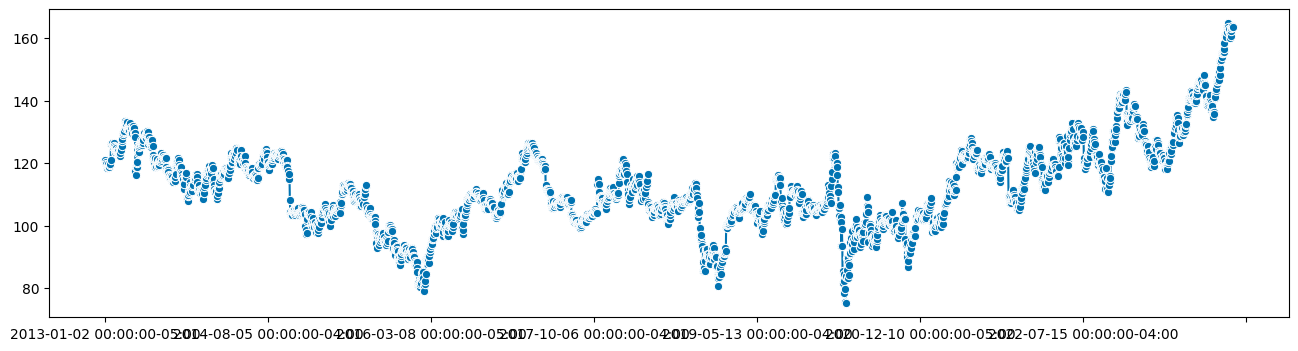

In [72]:
from sktime.utils.plotting import plot_series

# plotting for visualization
plot_series(df_ibm)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

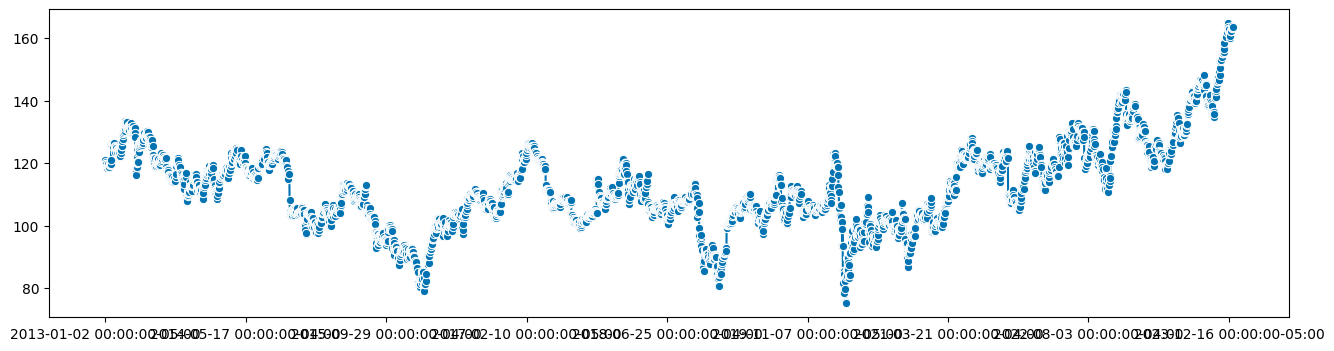

In [109]:
from sktime.utils.plotting import plot_series

# plotting for visualization
plot_series(filled_nas)

## Hypothesis testing: stationary data?

Dickey-Fuller Test
The Dickey-Fuller (DF) test was developed and popularized by Dickey and Fuller (1979). The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. The alternative hypothesis is generally stationarity or trend stationarity but can be different depending on the version of the test is being used.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

In [145]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(
    filled_nas['Close'],
    maxlag=None, 
    regression='c', 
    autolag='AIC', 
    store=False, 
    regresults=False)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('used_lag: %f' % result[2])
print('nobs: %f' % result[3])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -2.079516
p-value: 0.252831
used_lag: 13.000000
nobs: 4000.000000
Critial Values:
   1%, -3.4319858753661405
Critial Values:
   5%, -2.8622628402506254
Critial Values:
   10%, -2.5671547755625


In [ ]:
# the data is non-stationary
#The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.
#Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

      #(https://medium.com/@JDEconomics/how-to-test-for-stationarity-in-time-series-data-using-python-44d82890aa9d))


background data:

Visual Inspection: Plot the data and visually inspect it for any obvious trends. A trend exists if the general direction of the data changes over time. A deterministic trend is typically linear and can be modeled with a well-defined mathematical function, meaning that the long-term behavior of the time series is predictable.

Autocorrelation Function (ACF) Plots: ACF plots can help identify whether a time series is a random walk or has a deterministic trend. For a random walk, the ACF plot will have a single spike at lag 1 and fade away quickly after that. For a deterministic trend, the ACF plot will have significant lags beyond 1.

Statistical Tests: Use statistical tests such as the Augmented Dickey-Fuller (ADF) test to formally test the stationarity of the data. If the p-value resulting from the test is less than your chosen significance level (often 0.05), you reject the null hypothesis and conclude that the series is stationary. If the p-value is greater than your significance level, you fail to reject the null hypothesis and conclude that the series is non-stationary .

Detrending: If the time series exhibits a deterministic trend, you can detrend the data by regressing the series on a high-order polynomial function of time. The order of the polynomial can be determined by t-tests and F-tests as well as AIC and SBC measures of fit.

Differencing: If the time series is a random walk, you can make it stationary by differencing. This involves subtracting the previous observation from the current observation. Note that differencing will reduce the length of the series by one.

In [ ]:
# visual inspection


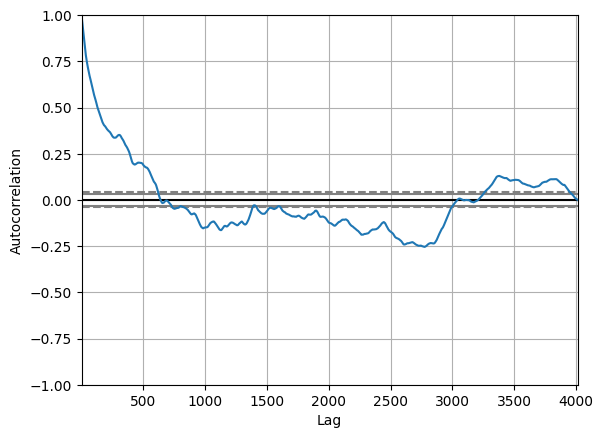

In [114]:
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(filled_nas)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

The Autocorrelation plot for the data is:


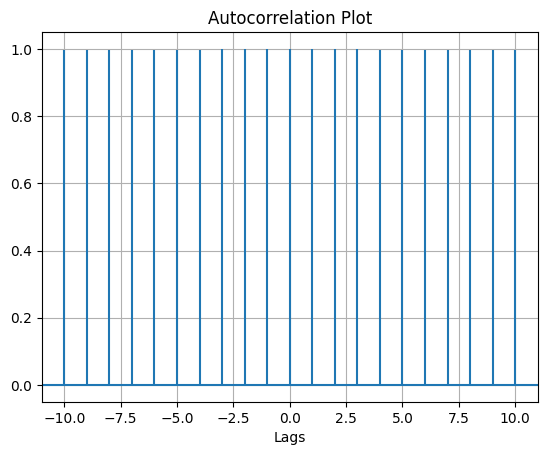

In [117]:
# Adding plot title.
plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
if isinstance(filled_nas, pd.DataFrame):
    filled_nas_val = filled_nas.iloc[:, 0] # Select the first column as a Series
elif isinstance(filled_nas, pd.Series):
    filled_nas_val = filled_nas
else:
    filled_nas_val = filled_nas

plt.acorr(filled_nas_val, maxlags = 10) 
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

## Model building